In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode

In [2]:
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 8)}

In [3]:
# Params

folder_labels = 'Labels'

len_list_calc_normal = 40
len_list_calc_focus = 15

thresould_quantile = 1.5
jump_after_stimulus = 50

fps_exam = 30

time_before_stimul = 2
time_after_sitmul = 3

outlier_loop = 1
alter_to = 'median' # ['mode', 'median']

In [4]:
def make_path(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

In [5]:
def remove_labels(path_out):
    try:
        for file in os.listdir(path_out):
            if ('.csv' in file) or ('.pdf' in file) or ('.txt' in file):
                remove = '{}/{}'.format(path_out, file)
                os.remove(remove)
    except OSError as e:
        print("Failed with:", e.strerror) # look what it says
        print("Error code:", e.code)

In [6]:
path_information = '/media/marcos/Dados/Projects/Datasets/Exams/informations_exams'
path_labels = '/media/marcos/Dados/Projects/Results/PupilDeep/{}'.format(folder_labels)

path_out = '/media/marcos/Dados/Projects/Results/PupilDeep/{}/process'.format(folder_labels)

path_process_labels = '{}/process_labels'.format(path_out)
path_original_graphs = '{}/original_graphs'.format(path_out)
path_process_graphs = '{}/process_graphs'.format(path_out)

path_out_csv = '{}/process.csv'.format(path_out)
path_log = '{}/log.txt'.format(path_out)

make_path(path_out)
make_path(path_process_labels)
make_path(path_original_graphs)
make_path(path_process_graphs)

remove_labels(path_out)
remove_labels(path_process_labels)
remove_labels(path_original_graphs)
remove_labels(path_process_graphs)

In [7]:
list_labels = [x for x in os.listdir(path_labels) if '_label.csv' in x]
print(list_labels)

['25080125_08_2019_08_32_38_label.csv', '25080225_08_2019_08_37_59_label.csv', '25080225_08_2019_08_40_12_label.csv', '25080325_08_2019_08_46_42_label.csv', '25080325_08_2019_08_48_58_label.csv', '25080425_08_2019_08_53_48_label.csv', '25080425_08_2019_08_55_59_label.csv', '25080425_08_2019_09_05_40_label.csv', '25080425_08_2019_09_08_25_label.csv']


In [8]:
def save_log(log):
    with open(path_log, 'a') as file_out:
        file_out.write('{}\n'.format(log))    

In [9]:
def outlier_treatment_loop(dataset):
    Q1 = dataset['radius'].quantile(0.25)
    Q3 = dataset['radius'].quantile(0.75)
    IQR = Q3 - Q1    
    
    tq = thresould_quantile
    filter_q = (dataset['radius'] >= Q1 - tq * IQR) & (dataset['radius'] <= Q3 + tq * IQR)
    filter_q = [frame for frame, avaliable in filter_q.iteritems() if not avaliable]
    
    for frame in  filter_q:
        list_radius = np.array([])
        list_radius = dataset.loc[frame:frame+len_list_calc_normal].radius
        dataset['radius'][frame] = int(np.median(list_radius))
    
    return dataset

In [10]:
def outlier_treatment(dataset):
    for i in range(outlier_loop):
        log = 'loop outlier treatment: {}'.format(i)
        save_log(log)
        dataset = outlier_treatment_loop(dataset)
    
    return dataset

In [11]:
def get_range_flash(dataset):
    filter_flash = dataset['flash'] > 0
    frames_flash = [frame for frame, avaliable in filter_flash.iteritems() if avaliable]    
    
    init_range = [frames_flash[0]]
    end_range = []
    
    for i in range(0, len(frames_flash)-1):
        if frames_flash[i]+1 != frames_flash[i+1]:
            end_range.append(frames_flash[i])
            init_range.append(frames_flash[i+1])
            
    end_range.append(frames_flash[len(frames_flash)-1])
    
    return init_range, end_range

In [12]:
def treat_dataset(dataset):
    init_range, end_range = get_range_flash(dataset)
    
    aux = 0
    for i in range(0, len(init_range)):        
        flash_dataset = dataset.loc[init_range[i]:end_range[i]]
        work_dataset = dataset.loc[aux:init_range[i]-1]
        
        frames_mod = mode(work_dataset['radius'])[0][0]
        frames_median = work_dataset['radius'].median()
        new_radius = frames_mod if alter_to == 'mode' else frames_median
        
        for index, item in flash_dataset.iterrows():
            dataset['radius'][index] = new_radius
                
        for index, item in work_dataset.iterrows():
            len_list = len_list_calc_normal
            if index > init_range[0]:
                if index <= aux + jump_after_stimulus:
                    len_list = len_list_calc_focus
                    
            range_dataset = work_dataset.loc[index:index+len_list]
            frames_mod = mode(range_dataset['radius'])[0][0]
            frames_median = range_dataset['radius'].median()
            new_radius = frames_mod if alter_to == 'mode' else frames_median
            dataset['radius'][index] = new_radius
        
        aux = end_range[i]+1
    
    return dataset

In [13]:
def get_information_exam(label):
    name_information = label.replace('_label.csv', '.log')
    file_information = '{}/{}'.format(path_information, name_information)
    
    patient = ''
    param = ''
    stimulus = []
    with open(file_information, 'r') as information:
        for line in information.readlines():            
            if 'PAC' in line:
                patient = line[line.rfind(':')+2:len(line)-1]
            if 'PRM' in line:
                param = line[line.rfind(':')+2:len(line)-1]
            if 'ATV' in line:
                stimul = line[line.rfind(':')+2:len(line)-1]
                init_stimul = line[0:line.rfind('-')-1]
            if 'DTV' in line:
                end_stimul = line[0:line.rfind('-')-1]
                stimulus.append({'stimul': stimul,
                                 'init_stimul': init_stimul,
                                 'end_stimul': end_stimul})
    
    return patient, param, stimulus

In [14]:
def create_params_out(label, dataset):
    patient, param, stimulus = get_information_exam(label)
    
    init_range, end_range = get_range_flash(dataset)
    
    if len(stimulus) > len(init_range):
        raise Exception('Number of stimulus is diferent of stimulus found in information!')    
    
    stimul1 = '' if len(stimulus) < 1 else stimulus[0]['stimul']
    init_stimul1 = '' if len(stimulus) < 1 else stimulus[0]['init_stimul']
    end_stimul1 = '' if len(stimulus) < 1 else stimulus[0]['end_stimul']    
    
    if len(init_range) > 0:
        position_before = init_range[0]-(time_before_stimul*fps_exam)
        position_after = end_range[0]+(time_after_sitmul*fps_exam)
                
        size_before_stimul1 = dataset['radius'][position_before]
        size_after_stimul1 = dataset['radius'][position_after]
    else:
        size_before_stimul1 = 0
        size_after_stimul1 = 0    
    
    stimul2 = '' if len(stimulus) < 2 else stimulus[1]['stimul']
    init_stimul2 = '' if len(stimulus) < 2 else stimulus[1]['init_stimul']
    end_stimul2 = '' if len(stimulus) < 2 else stimulus[1]['end_stimul']
    
    if len(init_range) > 1:
        position_before = init_range[1]-(time_before_stimul*fps_exam)
        position_after = end_range[1]+(time_after_sitmul*fps_exam)
                
        size_before_stimul2 = dataset['radius'][position_before]
        size_after_stimul2 = dataset['radius'][position_after]
    else:
        size_before_stimul2 = 0
        size_after_stimul2 = 0
    
    stimul3 = '' if len(stimulus) < 3 else stimulus[2]['stimul']
    init_stimul3 = '' if len(stimulus) < 3 else stimulus[2]['init_stimul']
    end_stimul3 = '' if len(stimulus) < 3 else stimulus[2]['end_stimul']
    
    if len(init_range) > 2:
        position_before = init_range[2]-(time_before_stimul*fps_exam)
        position_after = end_range[2]+(time_after_sitmul*fps_exam)
                
        size_before_stimul3 = dataset['radius'][position_before]
        size_after_stimul3 = dataset['radius'][position_after]
    else:
        size_before_stimul3 = 0
        size_after_stimul3 = 0    
        
    param_out = [patient, param, stimul1, size_before_stimul1, init_stimul1, end_stimul1, size_after_stimul1,
                 stimul2, size_before_stimul2, init_stimul2, end_stimul2, size_after_stimul2,
                 stimul3, size_before_stimul3, init_stimul3, end_stimul3, size_after_stimul3,
                 0, 0, 0, 0]
    return param_out

In [15]:
def plot_graph(dataset, path_save, title):
    title_graph = '{}\nlsrn: {}, lsrf: {}, tq: {}, ol: {}, at: {}, '.format(
        title, len_list_calc_normal, len_list_calc_focus, thresould_quantile, outlier_loop, alter_to)
    
    img = dataset.plot.line(x='frame', y='radius', linestyle='-', markevery=100, marker='o', title=title)
    img.figure.savefig('{}/{}.pdf'.format(path_save, title.replace('.csv', '')))

In [16]:
csv_out_header = 'patient,param,stimul1,size_before_stimul1,init_stimul1,end_stimul1,size_after_stimul1'

csv_out_header = '{},{}'.format(csv_out_header,
                                'stimul2,size_before_stimul2,init_stimul2,end_stimul2,size_after_stimul2')

csv_out_header = '{},{}'.format(csv_out_header,
                                'stimul3,size_before_stimul3,init_stimul3,end_stimul3,size_after_stimul3')

csv_out_header = '{},{}'.format(csv_out_header,
                                'exam_eye_size_mean,exam_meam_mean,exam_std_mean,exam_median_mean')
print(csv_out_header)

patient,param,stimul1,size_before_stimul1,init_stimul1,end_stimul1,size_after_stimul1,stimul2,size_before_stimul2,init_stimul2,end_stimul2,size_after_stimul2,stimul3,size_before_stimul3,init_stimul3,end_stimul3,size_after_stimul3,exam_eye_size_mean,exam_meam_mean,exam_std_mean,exam_median_mean


In [17]:
def create_csv_general(args):
    if len(args) != len(csv_out_header.split(',')):
        raise Exception('Numbers of paramns for generate full dataset is diferente of header!')
    
    args = [str(x).replace(',','-') for x in args]
    information = ','.join(args)
    with open(path_out_csv, 'a') as csv_out:
        csv_out.write('{}\n'.format(information))

In [18]:
create_csv_general(csv_out_header.split(','))

/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marcos/anaconda3/lib/python3.7/site-packages/ipykern

Exception: Number of stimulus is diferent of stimulus found in information!

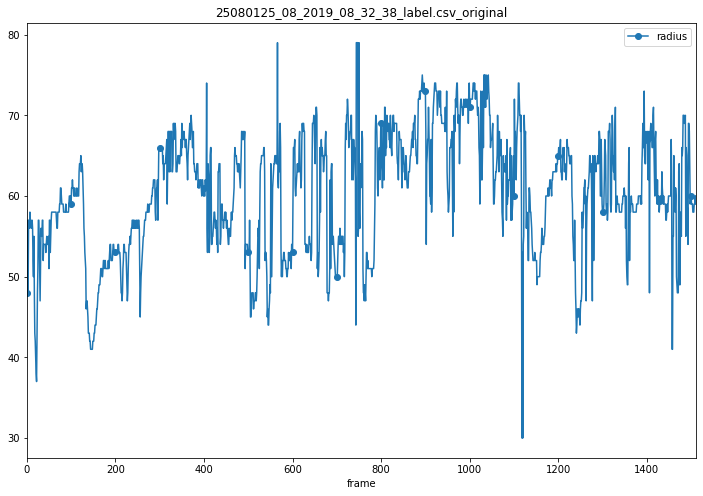

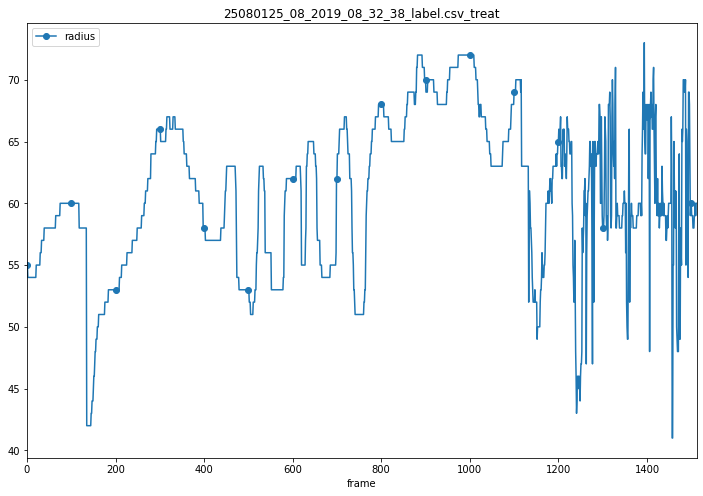

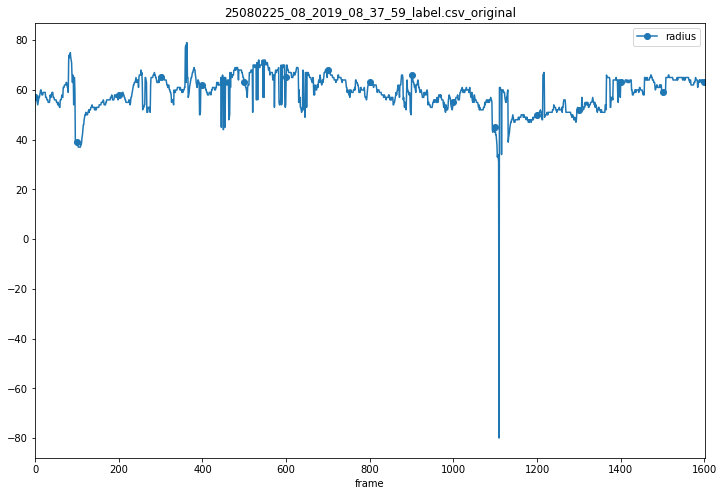

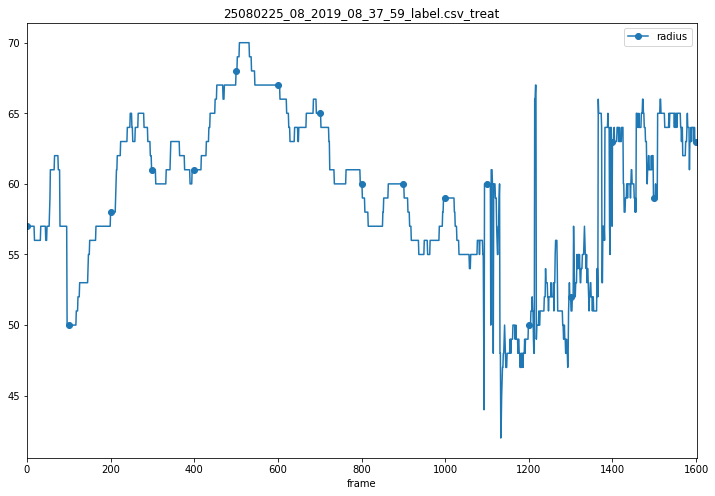

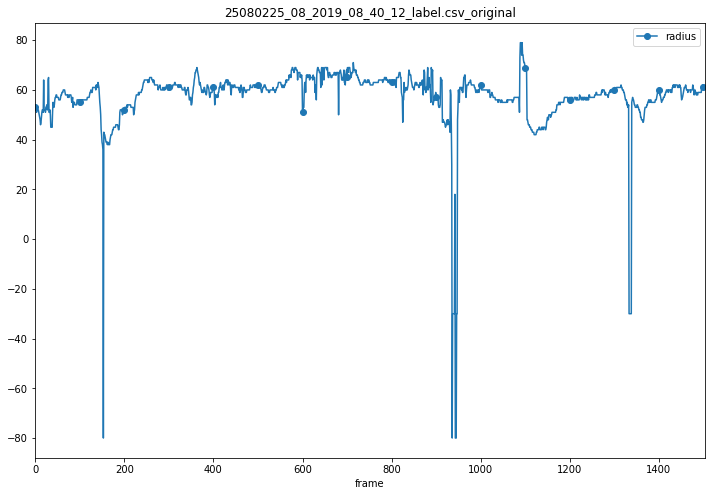

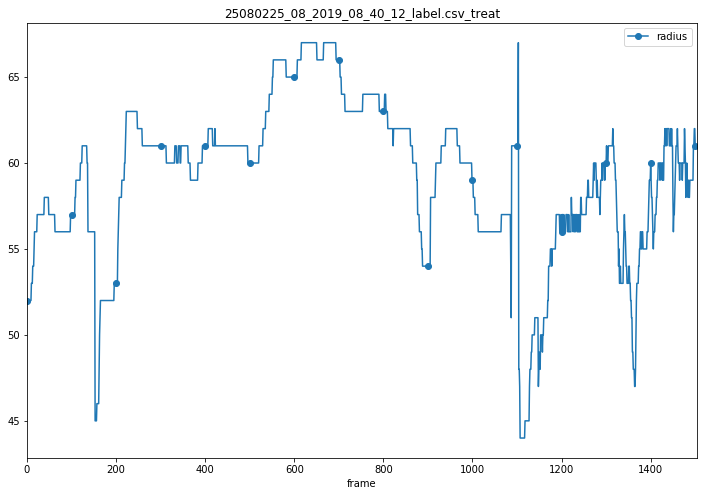

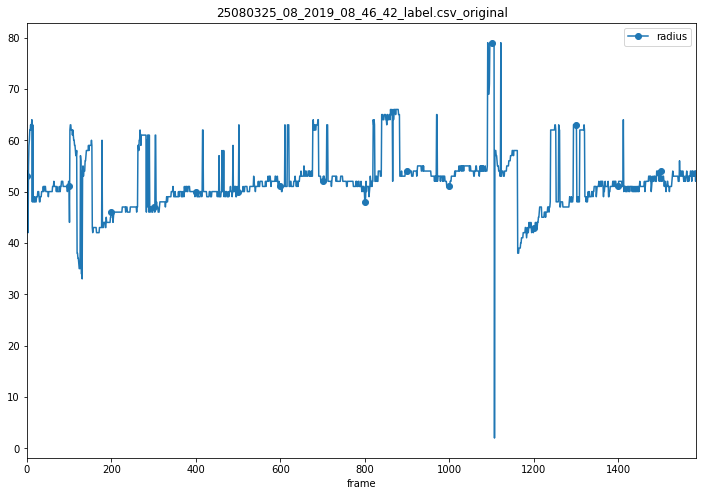

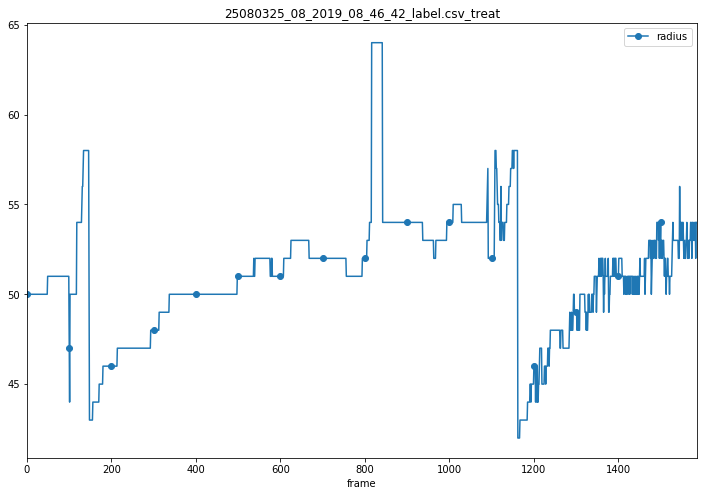

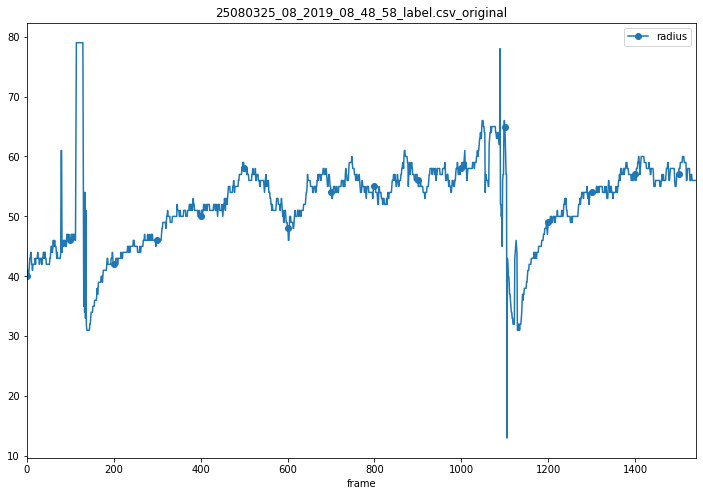

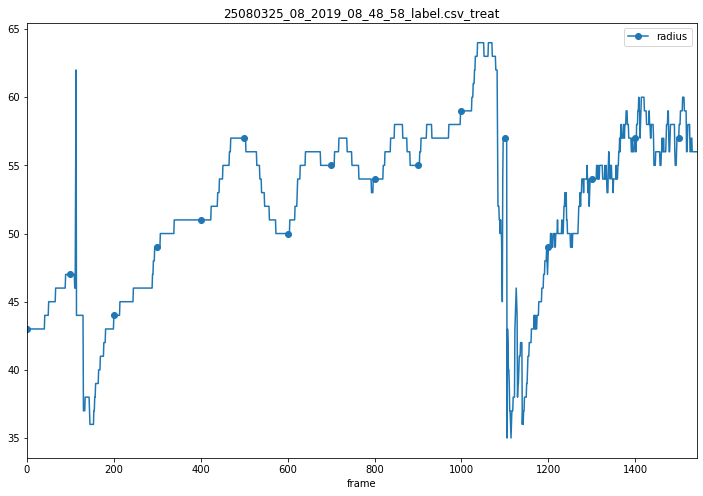

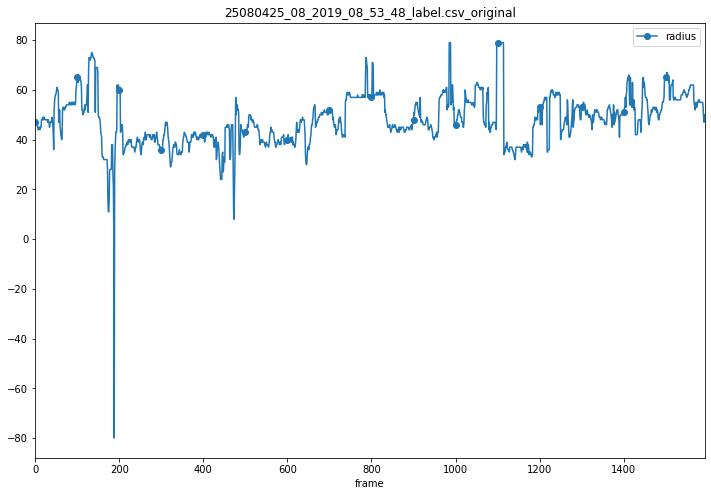

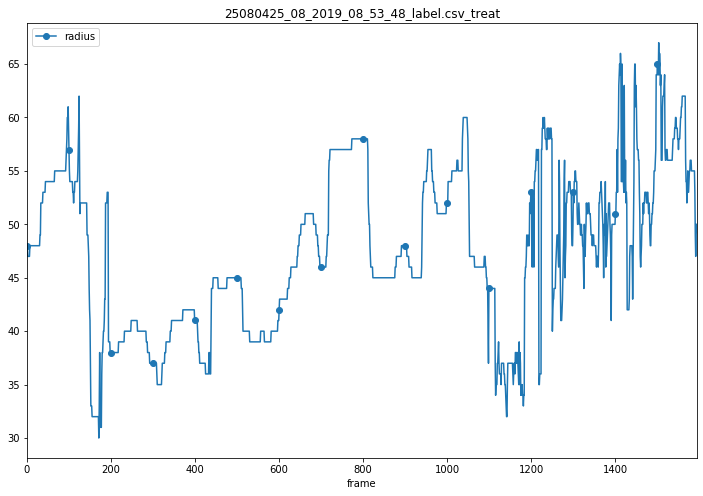

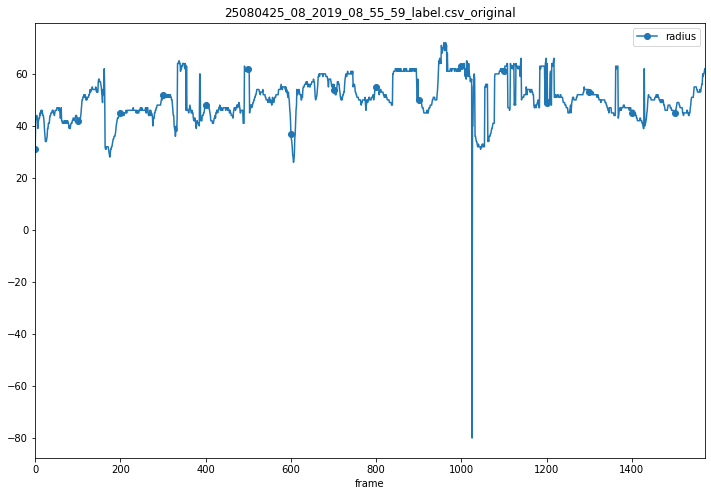

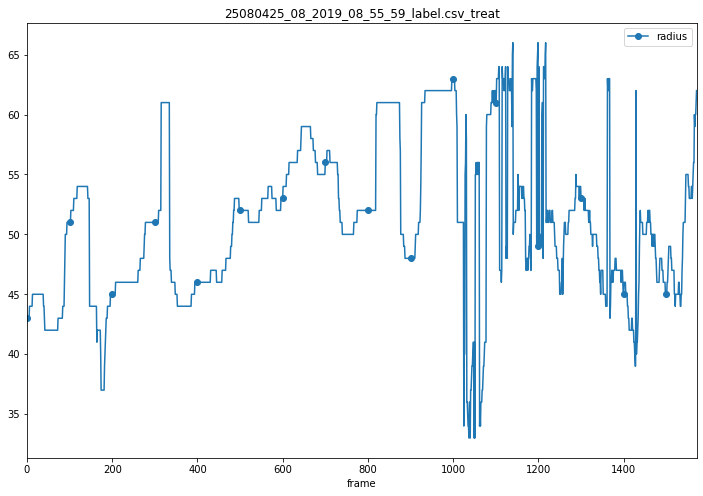

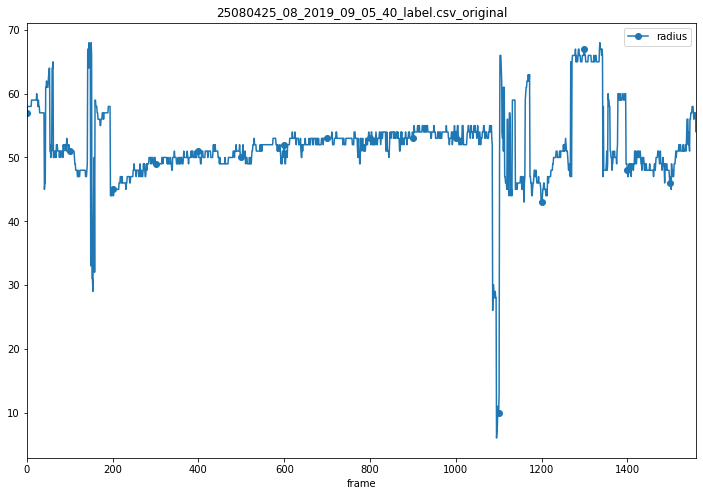

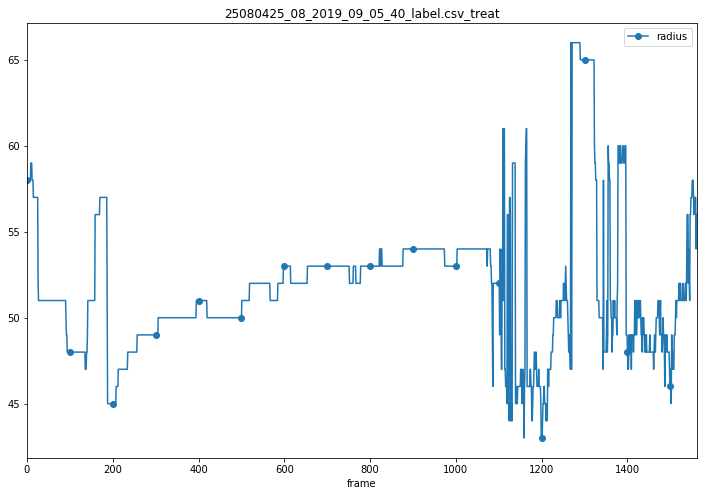

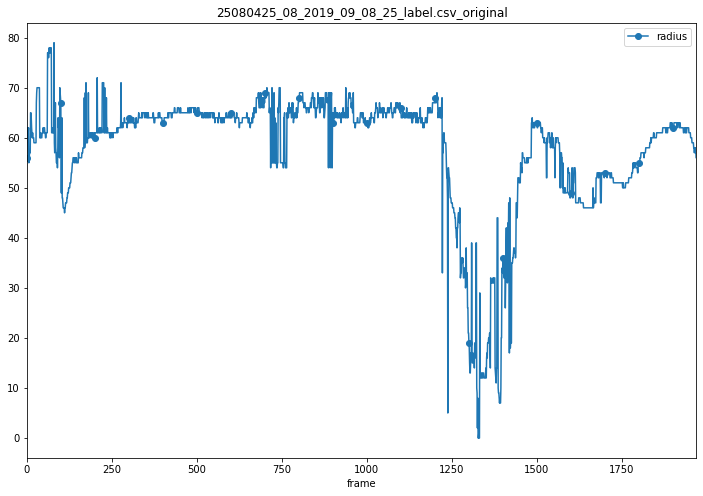

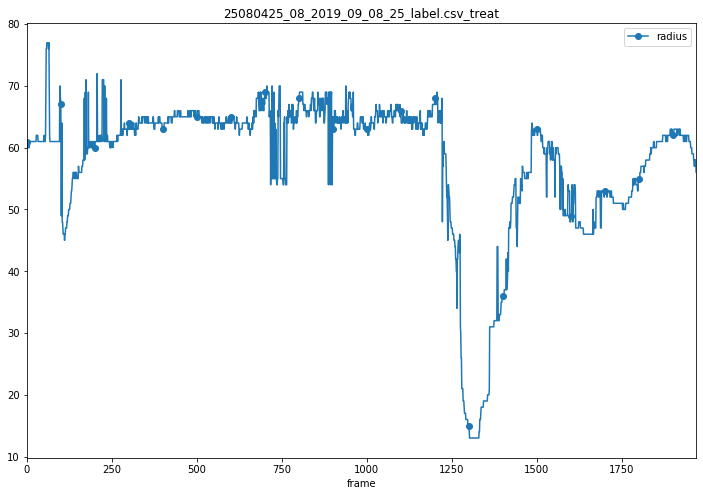

In [19]:
for label in list_labels:    
    file_in = '{}/{}'.format(path_labels, label)
    file_out = '{}/{}'.format(path_process_labels, label)
        
    dataset = pd.read_csv(file_in)
    plot_graph(dataset, path_original_graphs, '%s_%s' % (label, 'original'))

    dataset = outlier_treatment(dataset)
    dataset = treat_dataset(dataset)
    plot_graph(dataset, path_process_graphs, '%s_%s' % (label, 'treat'))
    
    param_out = create_params_out(label, dataset)
    create_csv_general(param_out)

    dataset.to_csv(file_out, index = False, header=True)